# Exercise 3 Quantitative Measures from ERP signals 

### Exercises 3 and 4 completes our discussion of extracting features from EEG experiments for building relationships with data. 

#### Exercise 3 is focused on extracting ERP measures (peak amplitude and latency) from ERP averages.  

### We will come back to these EEG measurements when we learn about classifiers.

## Face Perception Experiment 

### These data were extracted from the ERP CORE (https://osf.io/thsqg/wiki/home/).  

### These are data from the experiment, **N170 Face Perception Experiment**

### Some details of the experiment - 
*   The stimulus consists of four types of stimuli - Faces. Cars. Scrambled Faces, Scrambled Cars
*   On any trial one of these stimuli are presented (with probability 0.25)
*   On each trial, an image of a face, car, scrambled face, or scrambled car was presented in the center of the screen, and participants indicated whether a given stimulus was an “object” (face or car) or a “texture” (scrambled face or scrambled car)

## THIS IS ONE OF THE STIMULUS SETS FOR THE CLASS FINAL PROJECT.  IN THE FINAL PROJECT, THE TASK WILL BE TO CHARACTERIZE THE DIFFERENCES BETWEEN THE 4 STIMULUS CLASSES AND DEVELOP A CLASSIFIER MODEL TO PREDICT WHICH STIMULUS WAS PRESENTED ON EACH TRIAL. 


In [608]:
import numpy as np 
from matplotlib import pyplot as plt
from hdf5storage import loadmat, savemat 
from scipy.fftpack import fft
from scipy import signal  #THIS IS NEW!!!

#### There are 3 data files available for your inspection, 1_N170.mat, 2_N170.mat, 3_N170.mat 
#### The 3 files have the same experiment in different participants.  

In [609]:
data = loadmat('data/2_N170.mat')


In [610]:
channelnames = data['channelnames']
eeg = data['eeg']
eeg_time = data['eeg_time']
goodtrials = data['goodtrials']
nchannels = data['nchannels']
ntrials = data['ntrials']
response = data['response']
responsetime = data['responsetime']
samplingrate = data['samplingrate']
stimulus = data['stimulus']

# README 

### The information about the datafiles in an experiment is normally placed in a README file. 
### For convenience I am going to place that information here instead.

###  This data was obtained from the archive ERP CORE and reorganized for this class. 
###  Each file contains the data of one participant, indicated in the filename. 
###  The variables contained here are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `eeg_time` - the time relative to *stimulus onset* in each EEG observation.
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `stimulus` - the stimulus presented on each good trial, 1 = face, 2 = car, 3 = scrambled face, 4 = scrambled car 
*   `response` - variable indicating the response accuracy 1 = correct, -1 = incorrect, 0 = no response,
*   `responsetime` - time after stimulus onset when the subject provided a response. 
*   `goodtrials` - vector with value 1 if the trial had a response, 0 if no response or multiple responses.   

## Problem 1 

#### Compute the Event-related potential (ERP) separately for each stimulus type. 
#### Plot the data at electrodes corresponding to P3,Pz,P4 over parietal cortex, and PO7, O1,O2,PO8 over the occipital cortex.   
#### Apply filters and extract the P300/CPP amplitude and latency (timing of the peak after stimulus presentation) at electrode Pz. 
#### Apply filters and extract the N170 amplitude and latency (timing) at one of PO7,PO8 for the face and car stimuli.  Select the electrode that has the clearest N170 for all 3 participants data.   Alternatively, you could collapse the 2 electrodes data by averaging them together.   
#### For the scrambled face and scrambled car stimuli, use the latency of the face and car stimuli, and extract the voltage of the corresponding scrambled stimulus response.  
####
#### **Your notebook should run cleanly.  That is, I should be able to change which data file is being run, and it should be able to run and make all of the above plots and quantitative estimates.**  



In [611]:
erp_face = np.mean(eeg[(goodtrials == 1)&(stimulus == 1),:,:],axis =0);
erp_car = np.mean(eeg[(goodtrials == 1)&(stimulus == 2),:,:],axis =0);
erp_scrambled_face = np.mean(eeg[(goodtrials == 1)&(stimulus == 3),:,:],axis =0);
erp_scrambled_car = np.mean(eeg[(goodtrials == 1)&(stimulus == 4),:,:],axis =0);


<function matplotlib.pyplot.show(close=None, block=None)>

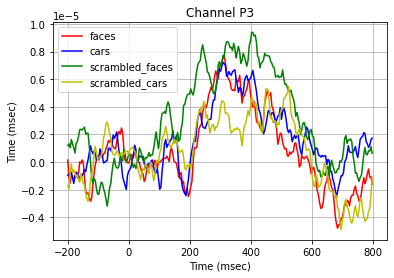

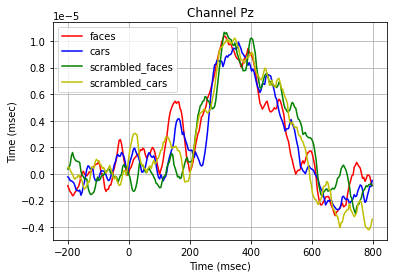

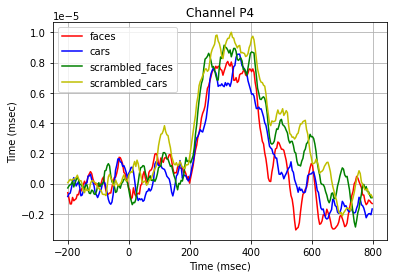

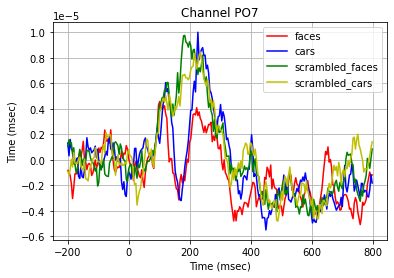

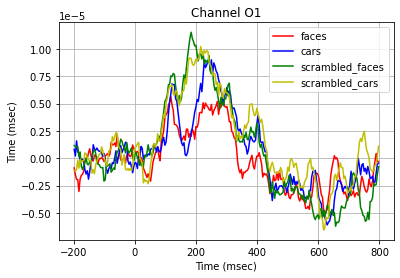

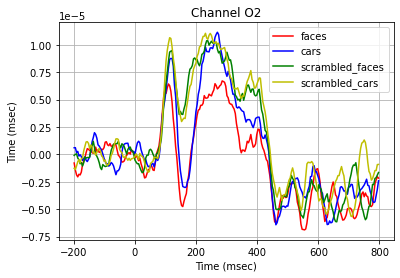

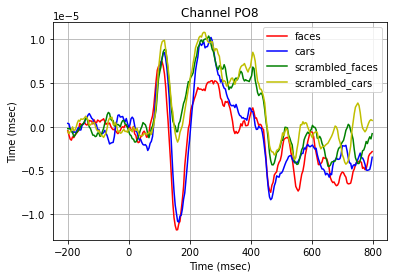

In [612]:
chans = [6,12,23,8,10,27,25]
for j in range(7):
    plt.figure()
    plt.plot(eeg_time,erp_face[chans[j],:],'r-')
    plt.plot(eeg_time,erp_car[chans[j],:],'b-')
    plt.plot(eeg_time,erp_scrambled_face[chans[j],:],'g-')
    plt.plot(eeg_time,erp_scrambled_car[chans[j],:],'y-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('faces','cars','scrambled_faces','scrambled_cars'))
plt.show


In [613]:
T = 1  #duration of the time series 
deltaf = 1/T # frequency resolution 
nsamp = np.shape(erp_face)[1] 
nf = int(nsamp/2) 
f = np.arange(0,nf)*deltaf 
fft_erp_face = fft(erp_face,axis =1)
amplitude_face = 2*np.abs(fft_erp_face)/nsamp/deltaf
nsamp = np.shape(erp_car)[1] 
nf = int(nsamp/2) 
f = np.arange(0,nf)*deltaf 
fft_erp_car = fft(erp_car,axis =1)
amplitude_car = 2*np.abs(fft_erp_car)/nsamp/deltaf

In [614]:
from eeg import makefilter,bodeplot
help(makefilter)

Help on function makefilter in module eeg:

makefilter(sr, fp, fs, gp=3, gs=20)
    Wrapper function around scipy filter functions.  
    Makes it convenient by providing frequency parameters in terms of 
    frequencies in Hz.   
    INPUT:  sr - sampling rate in Hz. 
            fp - pass frequency in Hz
            fs - stop frequency in Hz
            gp - pass band ripple in dB, default 3 dB
            gs - stop band attenuation in dB, default 20 dB
    OUTPUT: b,a filter coefficients. 
                    w,h for making bodeplot 
    Automatically detects the type of filter.  if fp < fs the filter
    is low pass but if fp > fs the filter is highpass.  
    It is recommended that you DO NOT use this filter, but instead use 
    makefiltersos to improve stability in high filter order scenarios



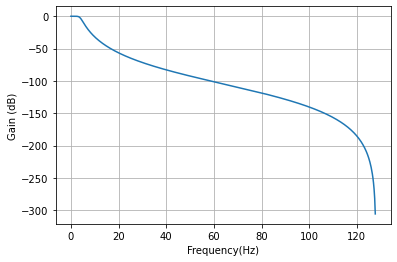

In [615]:
fp = 4
fs = 8
b,a,w,h = makefilter(samplingrate,fp,fs) 
bodeplot(w,h)

In [616]:
erpfilt_face = signal.filtfilt(b,a,erp_face,axis=1)  
erpfilt_car = signal.filtfilt(b,a,erp_car,axis=1) 
erpfilt_scrambled_face = signal.filtfilt(b,a,erp_scrambled_face,axis=1) 
erpfilt_scrambled_car = signal.filtfilt(b,a,erp_scrambled_car,axis=1) 

In [617]:
erpfilt_scrambled_car = signal.filtfilt(b,a,erp_scrambled_car,axis=1) 

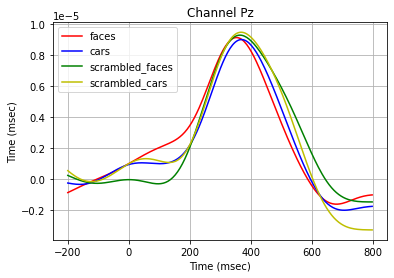

In [618]:
plt.plot(eeg_time,erpfilt_face[12,:],'r')
plt.plot(eeg_time,erpfilt_car[12,:],'b')
plt.plot(eeg_time,erpfilt_scrambled_face[12,:],'g')
plt.plot(eeg_time,erpfilt_scrambled_car[12,:],'y')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Time (msec)')
plt.grid()
plt.legend(('faces','cars','scrambled_faces','scrambled_cars'))
plt.show()

In [619]:
eegfilt = signal.filtfilt(b,a,eeg,axis=2)

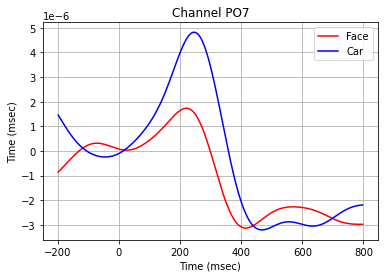

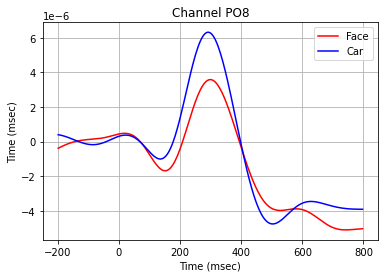

In [620]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erpfilt_face[chans[j],:],'r-')
    plt.plot(eeg_time,erpfilt_car[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Time (msec)')
    plt.grid()
    plt.legend(('Face','Car'))

plt.show()

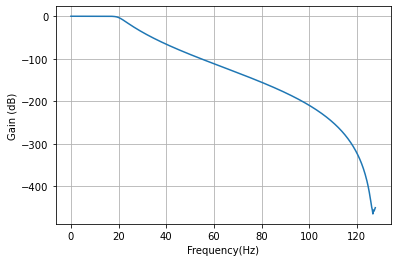

In [621]:
blow,alow,w,h = makefilter(256,20,25) #lowpass filter with the a cutoff of 20 Hz and stop at 25 Hz 
bodeplot(w,h)
erpfilt_face = signal.filtfilt(blow,alow,erp_face,axis=1)
erpfilt_car = signal.filtfilt(blow,alow,erp_car,axis=1)

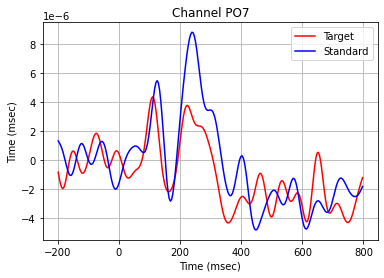

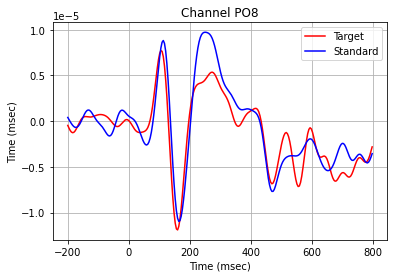

In [622]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erpfilt_face[chans[j],:],'r-')
    plt.plot(eeg_time,erpfilt_car[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Voltage')
    plt.grid()
    plt.legend(('face','car'))

plt.show()

/Users/adelinew/Documents/GitHub/COGS108/Exercises/eeg.py:79: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w,20*log10(abs(h)))


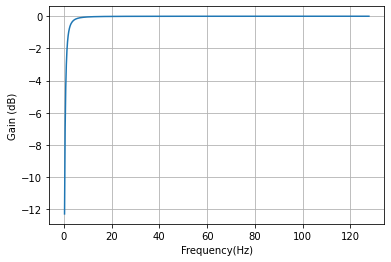

In [623]:
fp = 1
fs = 0.1
bhigh,ahigh,w,h = makefilter(samplingrate,fp,fs)  #Its a high pass filter because fp > fs  
bodeplot(w,h)

In [624]:
erpfilt_face = signal.filtfilt(bhigh,ahigh,erpfilt_face,axis=1) 
erpfilt_car = signal.filtfilt(bhigh,ahigh,erpfilt_car,axis=1)

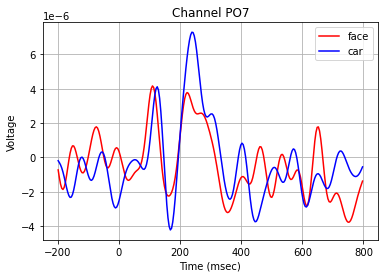

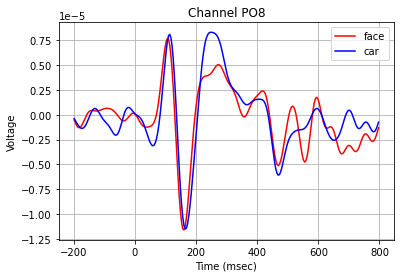

In [625]:
chans = [8,25]
for j in range(2):
    plt.figure()
    plt.plot(eeg_time,erpfilt_face[chans[j],:],'r-')
    plt.plot(eeg_time,erpfilt_car[chans[j],:],'b-')
    plt.title('Channel '+channelnames[chans[j]])
    plt.xlabel('Time (msec)')
    plt.ylabel('Voltage')
    plt.grid()
    plt.legend(('face','car'))

plt.show()

In [626]:
maxbin = 100
max_face = np.min(erpfilt_face[25,range(maxbin)])   
max_index_face = np.argmin(erpfilt_face[25,range(maxbin)]) 
max_time_face = eeg_time[max_index_face] 
voltage_scrambled_face = erp_scrambled_face[25][max_index_face]
print("The time for scrambled face:", max_time_face)
print("The latency for scrambled face:", voltage_scrambled_face)
max_car = np.min(erpfilt_car[25,range(maxbin)])   
max_index_car = np.argmin(erpfilt_car[25,range(maxbin)]) 
max_time_car = eeg_time[max_index_car] 
voltage_scrambled_car = erp_scrambled_car[25][max_index_car]
print("The time for scrambled car:", max_time_car)
print("The latency for scrambled car:", voltage_scrambled_car)


The time for scrambled face: 160.15625
The latency for scrambled face: -5.586081171587128e-07
The time for scrambled car: 164.0625
The latency for scrambled car: -1.4135596382399918e-06
